# ws 02 Face embedding

download .h5 at https://www.kaggle.com/suicaokhoailang/facenet-keras 

In [7]:
!pip install mtcnn -q


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: C:\Users\ASUS\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [8]:
'''from google.colab import drive
drive.mount('/content/drive/')

!ls '/content/drive/MyDrive/Colab Notebooks/datasets'''

"from google.colab import drive\ndrive.mount('/content/drive/')\n\n!ls '/content/drive/MyDrive/Colab Notebooks/datasets"

In [9]:
import numpy as np

from PIL import Image 
from mtcnn.mtcnn import MTCNN
from tqdm import tqdm


from os import listdir
from tensorflow.keras.models import load_model


img size: (3456, 3456)
img size: (1382, 1382)


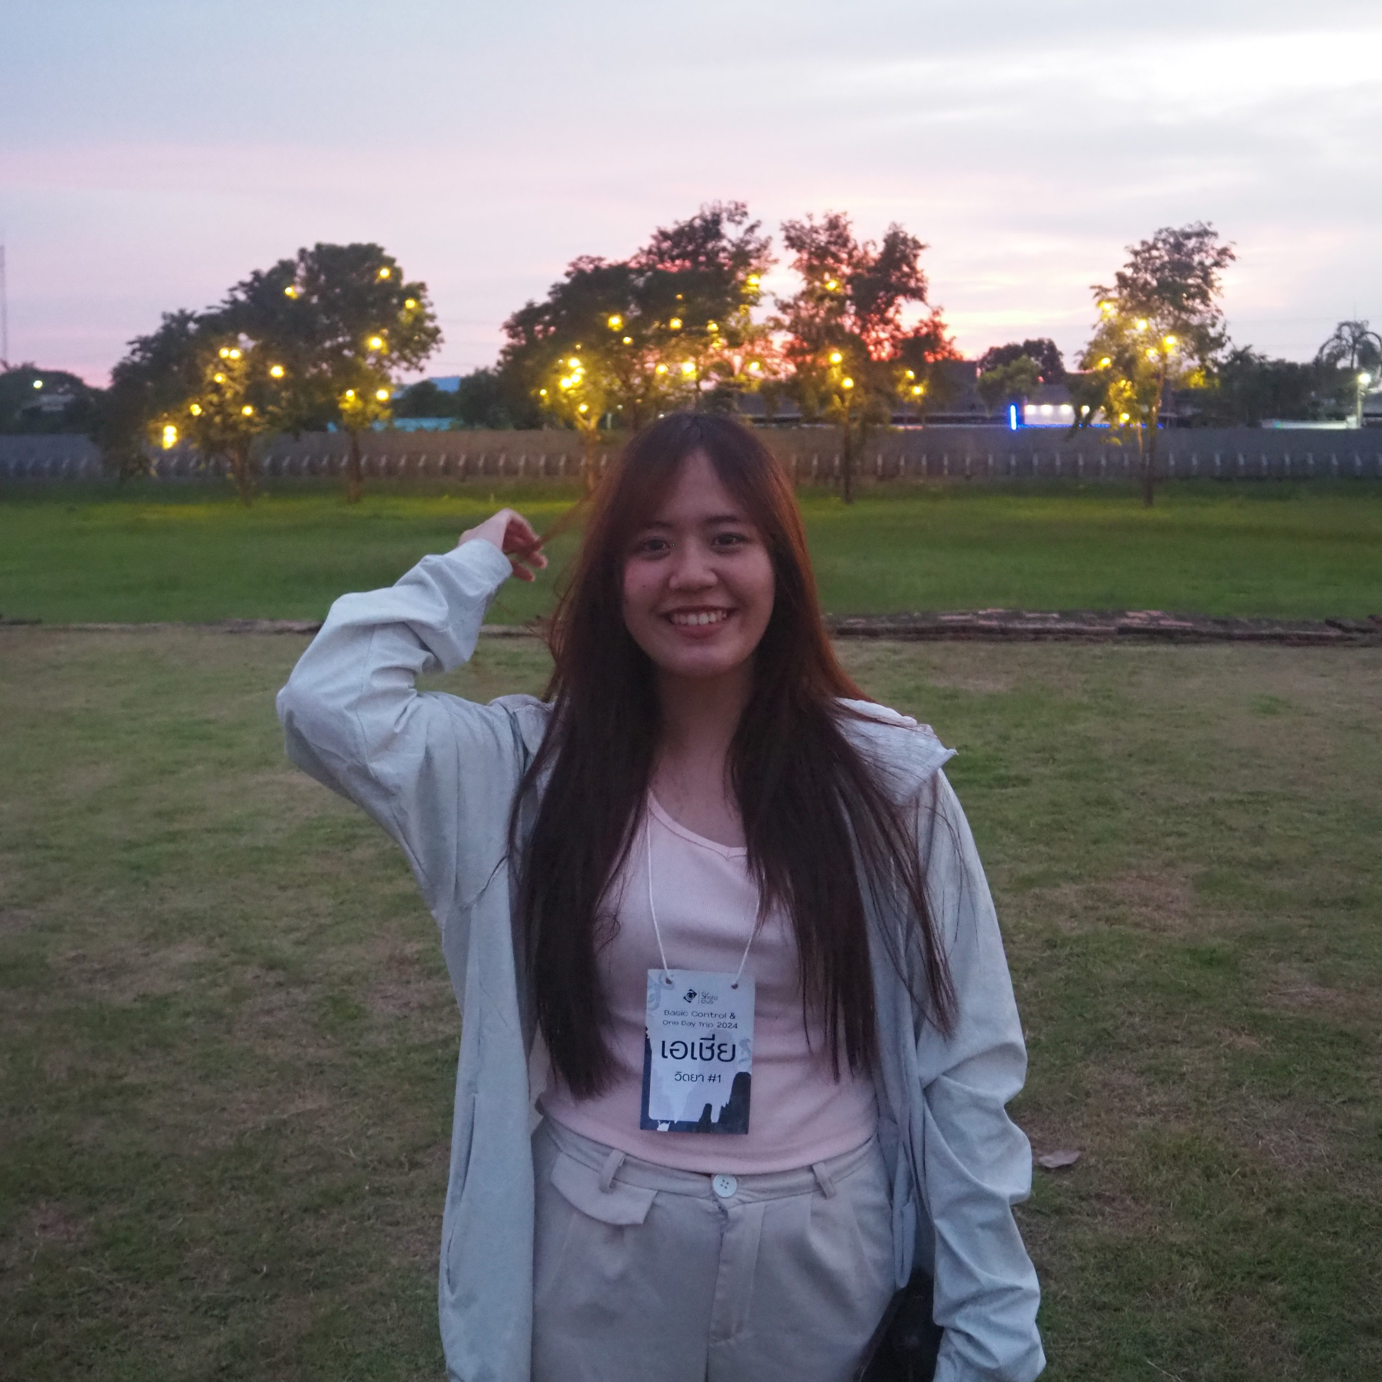

In [10]:
#rootdir = "/content/drive/MyDrive/Colab Notebooks/datasets/face/"

#filename = rootdir + 'train/Kobkiat/kobkiat1.jpg' 
filename = 'p1.jpg'

im = Image.open(filename).convert("RGB")
print('img size:', im.size)
im

scale = 0.4

im = im.resize((round(im.size[0]*scale), round(im.size[1]*scale)))
print('img size:', im.size)
im

In [11]:
detector = MTCNN()

def extract_face(filename, required_size=(160, 160), detector=detector):
    image = Image.open(filename).convert('RGB')
    im_arr = np.array(image)
    faces = detector.detect_faces(im_arr) 

    x1, y1, width, height = faces[0]['box']
    x2, y2 = x1 + width, y1 + height
    face = im_arr[y1:y2, x1:x2]

    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

(160, 160, 3)


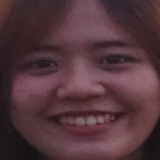

In [12]:
face_pixels = extract_face(filename)
print(face_pixels.shape)
Image.fromarray(face_pixels)

## Embedding

In [13]:
#modelpath = '/content/drive/MyDrive/Colab Notebooks/'

#facenet_model = load_model(modelpath + 'facenet_keras.h5')
facenet_model = load_model('archive/facenet_keras.h5')

print(facenet_model.inputs)
print(facenet_model.outputs)

EOFError: EOF read where object expected

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Flatten, Dense, Dropout, GlobalAveragePooling2D, concatenate
from tensorflow.keras.models import Model

def inception_resnet_block(input_tensor, filters, scale=0.1):
    """Inception-ResNet block for building the Inception ResNet V1 model."""
    # Branch 1
    branch_1 = Conv2D(filters, (1, 1), padding='same')(input_tensor)
    branch_1 = BatchNormalization()(branch_1)
    branch_1 = Activation('relu')(branch_1)

    # Branch 2
    branch_2 = Conv2D(filters, (1, 1), padding='same')(input_tensor)
    branch_2 = BatchNormalization()(branch_2)
    branch_2 = Activation('relu')(branch_2)
    branch_2 = Conv2D(filters, (3, 3), padding='same')(branch_2)
    branch_2 = BatchNormalization()(branch_2)
    branch_2 = Activation('relu')(branch_2)

    # Branch 3
    branch_3 = Conv2D(filters, (1, 1), padding='same')(input_tensor)
    branch_3 = BatchNormalization()(branch_3)
    branch_3 = Activation('relu')(branch_3)
    branch_3 = Conv2D(filters, (3, 3), padding='same')(branch_3)
    branch_3 = BatchNormalization()(branch_3)
    branch_3 = Activation('relu')(branch_3)
    branch_3 = Conv2D(filters, (3, 3), padding='same')(branch_3)
    branch_3 = BatchNormalization()(branch_3)
    branch_3 = Activation('relu')(branch_3)

    # Concatenate branches
    mixed = concatenate([branch_1, branch_2, branch_3])

    # Shortcut connection
    up = Conv2D(input_tensor.shape[-1], (1, 1), padding='same')(mixed)
    up = tf.keras.layers.Lambda(lambda x: x * scale)(up)

    # Residual connection
    output = tf.keras.layers.Add()([input_tensor, up])
    output = Activation('relu')(output)

    return output

def build_facenet_model(input_shape=(160, 160, 3)):
    """Build the FaceNet model based on Inception ResNet V1."""
    inputs = Input(shape=input_shape)
    
    # Stem
    x = Conv2D(32, (3, 3), strides=(2, 2), padding='valid')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    # Inception-ResNet Blocks
    for _ in range(5):
        x = inception_resnet_block(x, filters=32)
    for _ in range(10):
        x = inception_resnet_block(x, filters=64)
    for _ in range(5):
        x = inception_resnet_block(x, filters=128)
    
    # Final layers
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(128, activation=None)(x)
    outputs = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(outputs)

    # Create model
    model = Model(inputs, outputs)
    return model

# สร้างโมเดล
facenet_model = build_facenet_model()
#facenet_model.summary()
print(facenet_model.inputs)
print(facenet_model.outputs)

facenet_model.save('facenet_model.h5')




[<KerasTensor shape=(None, 160, 160, 3), dtype=float32, sparse=False, name=keras_tensor>]
[<KerasTensor shape=(None, 128), dtype=float32, sparse=False, name=keras_tensor_516>]


In [23]:
print('min max:', face_pixels.min(), face_pixels.max())

min max: -1.8583642 3.099727


In [24]:
face_pixels = face_pixels.astype('float32')  
mean = face_pixels.mean()                   
std = face_pixels.std()               
face_pixels = (face_pixels - mean)/std       
sample = np.expand_dims(face_pixels, axis=0)
emb_face = facenet_model.predict(sample)
emb_face.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


(1, 128)

In [25]:
emb_face[0][:10]

array([-8.45616378e-05, -7.66434073e-02, -1.22055516e-01,  1.03106216e-01,
        3.15381251e-02, -5.50392317e-03, -7.35210162e-03,  9.20535624e-02,
        5.93356825e-02, -8.53065252e-02], dtype=float32)

In [26]:
np.min(emb_face), np.max(emb_face) 

(-0.31277257, 0.1966777)

## ws03 similarity

In [27]:
def get_embedding(facenet_model, face):
    face_pixels = face.astype('float32') 
    mean = face_pixels.mean()                  
    std = face_pixels.std()                    
    face_pixels = (face_pixels - mean)/std       
    sample = np.expand_dims(face_pixels, axis=0)
    emb_face = facenet_model.predict(sample)
    return emb_face[0]

def euclideanDistance(source_represent, test_represent):
    euclidean_dist = source_represent - test_represent
    euclidean_dist = np.sum(np.multiply(euclidean_dist, euclidean_dist))
    euclidean_dist = np.sqrt(euclidean_dist)
    return euclidean_dist

def dist_face(model, file1, file2):
    im_arr1 = extract_face(file1)
    emd1 = get_embedding(model, im_arr1)

    im_arr2 = extract_face(file2)
    emd2 = get_embedding(model, im_arr2)
    return euclideanDistance(emd1, emd2)

In [28]:
#kob1 = rootdir + 'kobkiat7.jpg'
#kob2 = rootdir + 'kobkiat9.jpg'

#print(dist_face(facenet_model, kob1, kob2))
print(dist_face(facenet_model, 'p1.jpg', 'p2.jpg'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
0.046203133


In [29]:
def cosineSimilarity(source_represent, test_represent):
    a = np.matmul(np.transpose(source_represent), test_represent)
    b = np.sum(np.multiply(source_represent, source_represent))
    c = np.sum(np.multiply(test_represent, test_represent))
    return (a / (np.sqrt(b) * np.sqrt(c)))
 
def cosine_face(model, file1, file2):
    im_arr1 = extract_face(file1)
    emd1 = get_embedding(model, im_arr1)

    im_arr2 = extract_face(file2)
    emd2 = get_embedding(model, im_arr2)
    return cosineSimilarity(emd1, emd2)

#print(cosine_face(facenet_model, kob1, kob2))
#print(cosine_face(facenet_model, kob1, ben1))
print(cosine_face(facenet_model, 'p1.jpg', 'p2.jpg'))
print(cosine_face(facenet_model, 'p1.jpg', 'pc.jpg'))
print(cosine_face(facenet_model, 'p1.jpg', 'pp.jpg'))
print(cosine_face(facenet_model, 'p1.jpg', 'ps.jpg'))

#cosine_similar = cosine_face(facenet_model, kob1, kob2)
cosine_similar = cosine_face(facenet_model, 'p1.jpg', 'p2.jpg')

print("cosine similarity: ", cosine_similar)
threshold = 0.5
if cosine_similar >= threshold:
    print("verified...  same person")
else:
    print("unverified!  Different person!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
0.99893266
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
0.9960785
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
0.99670374
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
0.9921782
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
cosine similarity:  0.99893266
verified...  same person


# ws 04 recog

download faces at https://www.kaggle.com/dansbecker/5-celebrity-faces-dataset

In [30]:
# upload then unzip 

!unzip -q "/content/drive/MyDrive/Colab Notebooks/datasets/face_celebs_110.zip" -d "/content/drive/MyDrive/Colab Notebooks/datasets/"

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [31]:
!ls "/content/drive/MyDrive/Colab Notebooks/datasets/face_celebs_110/train/"

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [32]:
rootdir = "/content/drive/MyDrive/Colab Notebooks/datasets/face_celebs_110/"

30 mins for train (1s / face)

In [33]:
def load_face(dir):
    faces = list()
    for filename in tqdm(listdir(dir)):
        path = dir + filename
        face = extract_face(path) 
        faces.append(face)
    return faces

def load_dataset(dir):
    X, y = list(), list()
    for subdir in sorted(listdir(dir)):
        path = dir + subdir + '/'
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample(s) for class: %s" % (len(faces),subdir) ) 
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)

# load train dataset
#trainX, trainy = load_dataset(rootdir + 'train/')
trainX, trainy = load_dataset('datasets/train/')
print('X shape, y shape:', trainX.shape, trainy.shape)
# load test dataset
#testX, testy = load_dataset(rootdir + 'val/')
testX, testy = load_dataset('datasets/val/')
print(testX.shape, testy.shape)

np.savez_compressed('5_cele_faces_dataset.npz', trainX, trainy, testX, testy)

100%|██████████| 14/14 [00:01<00:00,  7.55it/s]


loaded 14 sample(s) for class: ben_afflek


100%|██████████| 16/16 [00:01<00:00,  8.76it/s]


loaded 16 sample(s) for class: elton_john


100%|██████████| 21/21 [00:02<00:00, 10.09it/s]


loaded 21 sample(s) for class: jerry_seinfeld


100%|██████████| 19/19 [00:01<00:00,  9.88it/s]


loaded 19 sample(s) for class: madonna


100%|██████████| 22/22 [00:02<00:00,  9.24it/s]


loaded 22 sample(s) for class: mindy_kaling
X shape, y shape: (92, 160, 160, 3) (92,)


100%|██████████| 5/5 [00:00<00:00,  9.51it/s]


loaded 5 sample(s) for class: ben_afflek


100%|██████████| 5/5 [00:00<00:00,  8.79it/s]


loaded 5 sample(s) for class: elton_john


100%|██████████| 5/5 [00:00<00:00,  9.06it/s]


loaded 5 sample(s) for class: jerry_seinfeld


100%|██████████| 5/5 [00:00<00:00,  9.78it/s]


loaded 5 sample(s) for class: madonna


100%|██████████| 5/5 [00:00<00:00, 10.33it/s]


loaded 5 sample(s) for class: mindy_kaling
(25, 160, 160, 3) (25,)


In [34]:
# load the face dataset
data = np.load('5_cele_faces_dataset.npz')

trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3'] 
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (92, 160, 160, 3) (92,) (25, 160, 160, 3) (25,)


## Embedding

In [35]:
#modelpath = '/content/drive/MyDrive/Colab Notebooks/'

#facenet_model = load_model(modelpath + 'facenet_keras.h5')
facenet_model = load_model('facenet_keras.h5')
print('Loaded Model')

EOFError: EOF read where object expected

In [160]:
model= facenet_model
print(model.layers[0].input_shape[0])
print(model.layers[-1].output_shape[-1])

AttributeError: 'InputLayer' object has no attribute 'input_shape'

In [36]:
#  train set
emdTrainX = list()
for face in tqdm(trainX):
    emd = get_embedding(facenet_model, face)
    emdTrainX.append(emd)
    
emdTrainX = np.asarray(emdTrainX)
print('Train Embedding shape', emdTrainX.shape)

# test set 
emdTestX = list()
for face in tqdm(testX):
    emd = get_embedding(facenet_model, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print('\nTest Embedding shape',emdTestX.shape)

# save arrays 
np.savez_compressed('5_celeb_faces_embeddings.npz', 
                    emdTrainX, trainy, emdTestX, testy)

  0%|          | 0/92 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


  1%|          | 1/92 [00:00<00:10,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


  2%|▏         | 2/92 [00:00<00:10,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  3%|▎         | 3/92 [00:00<00:09,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


  4%|▍         | 4/92 [00:00<00:11,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  7%|▋         | 6/92 [00:00<00:09,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


  8%|▊         | 7/92 [00:00<00:10,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


  9%|▊         | 8/92 [00:00<00:09,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 10%|▉         | 9/92 [00:01<00:10,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 11%|█         | 10/92 [00:01<00:10,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 12%|█▏        | 11/92 [00:01<00:09,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 13%|█▎        | 12/92 [00:01<00:09,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 14%|█▍        | 13/92 [00:01<00:08,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 15%|█▌        | 14/92 [00:01<00:10,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 16%|█▋        | 15/92 [00:01<00:09,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 18%|█▊        | 17/92 [00:01<00:08,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 21%|██        | 19/92 [00:02<00:07,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 22%|██▏       | 20/92 [00:02<00:07,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 23%|██▎       | 21/92 [00:02<00:07,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 25%|██▌       | 23/92 [00:02<00:07,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 27%|██▋       | 25/92 [00:02<00:06,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 29%|██▉       | 27/92 [00:02<00:06, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 32%|███▏      | 29/92 [00:03<00:06,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 33%|███▎      | 30/92 [00:03<00:06,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 34%|███▎      | 31/92 [00:03<00:06,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 35%|███▍      | 32/92 [00:03<00:06,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 36%|███▌      | 33/92 [00:03<00:06,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 38%|███▊      | 35/92 [00:03<00:05,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 39%|███▉      | 36/92 [00:03<00:05,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 40%|████      | 37/92 [00:04<00:05,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 41%|████▏     | 38/92 [00:04<00:05,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 42%|████▏     | 39/92 [00:04<00:05,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 43%|████▎     | 40/92 [00:04<00:05,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 45%|████▍     | 41/92 [00:04<00:05,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 46%|████▌     | 42/92 [00:04<00:05,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 47%|████▋     | 43/92 [00:04<00:05,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 48%|████▊     | 44/92 [00:04<00:06,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 49%|████▉     | 45/92 [00:04<00:05,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 50%|█████     | 46/92 [00:05<00:05,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 52%|█████▏    | 48/92 [00:05<00:04,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 54%|█████▍    | 50/92 [00:05<00:04,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 55%|█████▌    | 51/92 [00:05<00:04,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 57%|█████▋    | 52/92 [00:05<00:04,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 58%|█████▊    | 53/92 [00:05<00:04,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 59%|█████▊    | 54/92 [00:05<00:04,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 60%|█████▉    | 55/92 [00:06<00:03,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 62%|██████▏   | 57/92 [00:06<00:03,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 63%|██████▎   | 58/92 [00:06<00:03,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 64%|██████▍   | 59/92 [00:06<00:03,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 65%|██████▌   | 60/92 [00:06<00:03,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 66%|██████▋   | 61/92 [00:06<00:03,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 67%|██████▋   | 62/92 [00:06<00:03,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 68%|██████▊   | 63/92 [00:06<00:03,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 70%|██████▉   | 64/92 [00:07<00:03,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 71%|███████   | 65/92 [00:07<00:02,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 72%|███████▏  | 66/92 [00:07<00:02,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 73%|███████▎  | 67/92 [00:07<00:02,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 75%|███████▌  | 69/92 [00:07<00:02,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 76%|███████▌  | 70/92 [00:07<00:02,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 78%|███████▊  | 72/92 [00:07<00:02,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 80%|████████  | 74/92 [00:08<00:01,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 82%|████████▏ | 75/92 [00:08<00:01,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 83%|████████▎ | 76/92 [00:08<00:01,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 84%|████████▎ | 77/92 [00:08<00:01,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 85%|████████▍ | 78/92 [00:08<00:01,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 86%|████████▌ | 79/92 [00:08<00:01,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 88%|████████▊ | 81/92 [00:08<00:01,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 89%|████████▉ | 82/92 [00:08<00:01,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 90%|█████████ | 83/92 [00:08<00:00,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 91%|█████████▏| 84/92 [00:09<00:00,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 93%|█████████▎| 86/92 [00:09<00:00,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 95%|█████████▍| 87/92 [00:09<00:00,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 96%|█████████▌| 88/92 [00:09<00:00,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 97%|█████████▋| 89/92 [00:09<00:00,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 98%|█████████▊| 90/92 [00:09<00:00,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 99%|█████████▉| 91/92 [00:09<00:00,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


100%|██████████| 92/92 [00:09<00:00,  9.26it/s]


Train Embedding shape (92, 128)


  0%|          | 0/25 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  4%|▍         | 1/25 [00:00<00:02,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 12%|█▏        | 3/25 [00:00<00:02, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 20%|██        | 5/25 [00:00<00:01, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 28%|██▊       | 7/25 [00:00<00:01, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 36%|███▌      | 9/25 [00:00<00:01, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 44%|████▍     | 11/25 [00:01<00:01,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 48%|████▊     | 12/25 [00:01<00:01,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 56%|█████▌    | 14/25 [00:01<00:01,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 64%|██████▍   | 16/25 [00:01<00:00,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 72%|███████▏  | 18/25 [00:01<00:00,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 76%|███████▌  | 19/25 [00:01<00:00,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 80%|████████  | 20/25 [00:02<00:00,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 84%|████████▍ | 21/25 [00:02<00:00,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 88%|████████▊ | 22/25 [00:02<00:00,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 92%|█████████▏| 23/25 [00:02<00:00,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 96%|█████████▌| 24/25 [00:02<00:00,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|██████████| 25/25 [00:02<00:00,  9.53it/s]


Test Embedding shape (25, 128)


In [37]:
print(emdTrainX.shape, trainy.shape)
print(emdTestX.shape, testy.shape)

(92, 128) (92,)
(25, 128) (25,)


In [38]:
np.unique(trainy)[:5]

array(['ben_afflek', 'elton_john', 'jerry_seinfeld', 'madonna',
       'mindy_kaling'], dtype='<U14')

In [39]:
len(np.unique(trainy))  # classes

5

## Train

In [40]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)

out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)

# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)

# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)

# score
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)

print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=23.913, test=20.000


Predicted: 
['ben_afflek' 'elton_john' 'jerry_seinfeld' 'madonna' 'mindy_kaling'] 
[12.18197858 22.38946954 22.93746345 18.86852823 23.62256021]
Expected: ben_afflek


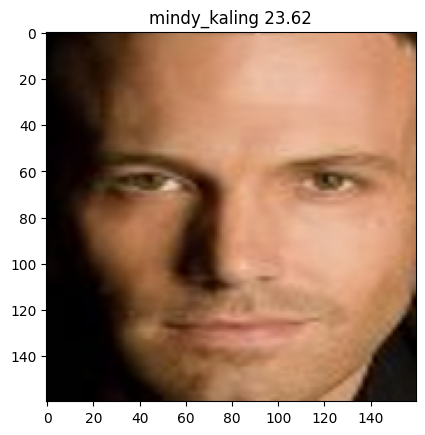

In [41]:
from random import choice
import matplotlib.pyplot as plt

selection = choice([i for i in range(testX.shape[0])])
random_face = testX[selection]
random_face_emd = emdTestX_norm[selection]
random_face_class = testy_enc[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction
samples = np.expand_dims(random_face_emd, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)

#  name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)

all_names = out_encoder.inverse_transform(np.unique(trainy_enc))  # 

print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
print('Expected: %s' % random_face_name[0])

# plot face
plt.imshow(random_face)

title = f'{predict_names[0]} {class_probability:.2f}'
plt.title(title)
plt.show()

img size: (200, 300)


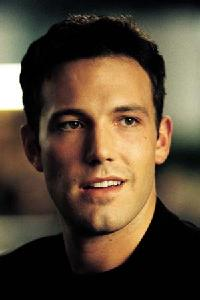

In [43]:
#filename = rootdir + 'val/name/kobkiat.jpg'
filename = 'datasets/val/ben_afflek/httpabsolumentgratuitfreefrimagesbenaffleckjpg.jpg'

im = Image.open(filename).convert("RGB")
print('img size:', im.size)
im

(160, 160, 3)


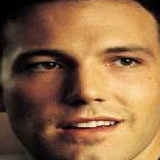

In [44]:
im_arr = extract_face(filename)
print(im_arr.shape)
Image.fromarray(im_arr)

In [45]:
print(emdTestX.shape, emdTestX_norm.shape)
print(emd.shape)

(25, 128) (25, 128)
(128,)


In [46]:
emd = get_embedding(facenet_model, im_arr)
emd = np.expand_dims(emd, axis=0)  # 
emd_norm = in_encoder.transform(emd)

yhat_class = model.predict(emd_norm)
yhat_prob = model.predict_proba(emd_norm)

class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print(f'predicted: {predict_names[0]} {class_probability:.2f}%') # 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
predicted: mindy_kaling 22.95%


In [47]:
print('Predicted: \n%s \n%s' % (all_names, (yhat_prob[0]*100).round(2)))

Predicted: 
['ben_afflek' 'elton_john' 'jerry_seinfeld' 'madonna' 'mindy_kaling'] 
[13.26 19.87 22.44 21.47 22.95]


## TNSE

In [50]:
from sklearn.preprocessing import LabelEncoder

out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)

trainy_enc.shape, np.unique(trainy_enc)

((92,), array([0, 1, 2, 3, 4]))

In [51]:
from sklearn.preprocessing import Normalizer

in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)

X shape (92, 128)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 92 samples in 0.001s...
[t-SNE] Computed neighbors for 92 samples in 0.396s...
[t-SNE] Computed conditional probabilities for sample 92 / 92
[t-SNE] Mean sigma: 0.037212
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.240646
[t-SNE] KL divergence after 900 iterations: 0.173808


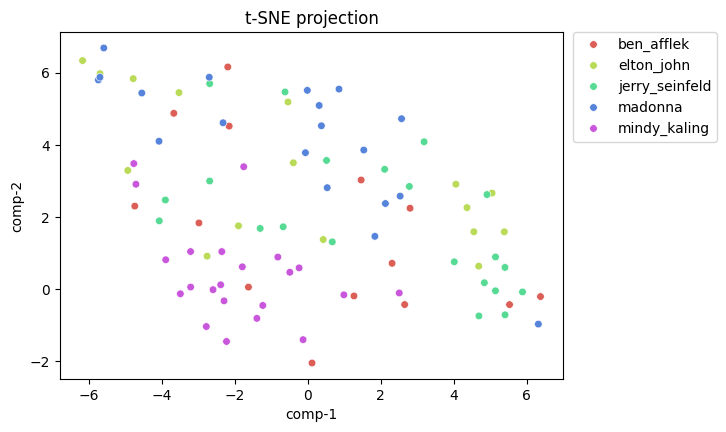

In [52]:
from sklearn.manifold import TSNE

import seaborn as sns
import pandas as pd

n_classes = len(np.unique(trainy_enc))

plt.figure(figsize=(6.5,4.5))

y_train = trainy_enc

x_mnist = emdTrainX_norm  

print('X shape', x_mnist.shape)

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x_mnist)
 
df = pd.DataFrame()
df["y"] = y_train
df['y_cls'] = trainy
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]


sns.scatterplot(x="comp-1", y="comp-2", s=30, hue=df.y_cls.tolist(), #7
                palette=sns.color_palette("hls", n_classes),
                # legend=False,
                data=df).set(title="t-SNE projection")

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
